In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#https://www.kaggle.com/kemical/kickstarter-projects
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix,  recall_score, precision_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import scale

In [3]:
df = pd.read_csv(r'C:\Users\PRM\Documents\Projects\Python\Kickstarter\ks-projects-201612.csv',encoding='cp1252')
df2 = pd.read_csv(r'C:\Users\PRM\Documents\Projects\Python\Kickstarter\ks-projects-201801.csv')
df = df.iloc[:,:-4]
df.columns = df.columns.str.strip()

C:\Users\PRM\AppData\Local\Programs\Python\Python37-32\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375


# Cleaning

In [5]:
l = ['1500']
i1 = df[df['deadline'].isin(l)].index
i2 = df[df['launched'].isin(l)].index
ll = np.array(i1,i2)
df = df.drop(index=ll)

df['deadline']=df['deadline'].astype(str).str[0:11]
df['launched']=df['launched'].astype(str).str[0:11]

df = df[df['deadline'].str.contains(r'[^a-zA-Z]')]
df = df[df['launched'].str.contains(r'[^a-zA-Z]')]

df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])

df['daysdiff'] = (df['deadline'] - df['launched']).dt.days

df = df[df['goal'].str.contains(r'[^a-zA-Z]')]
df = df[df['pledged'].str.contains(r'[^a-zA-Z]')]
df = df[df['category'].str.contains(r'[^0-9]')]
df = df[df['main_category'].str.contains(r'[^0-9]')]
df = df[df['currency'].str.contains(r'[^0-9]')]

df = df[df['state']!='undefined']

In [6]:
df['goal']=df['goal'].astype('float')
df['pledged']=df['pledged'].astype('float')
df['backers']=df['backers'].astype('int')
df['usd pledged']=df['usd pledged'].astype('float')

In [8]:

#currency conversions
df['rate'] = np.where(df['currency'] == 'GBP', 0.7456862, '')
df['rate'] = np.where(df['currency'] == 'USD', 1, df['rate'])
df['rate'] = np.where(df['currency'] == 'CAD', 1.281915, df['rate'])
df['rate'] = np.where(df['currency'] == 'NOK', 8.8239778, df['rate'])
df['rate'] = np.where(df['currency'] == 'AUD', 1.3826416, df['rate'])
df['rate'] = np.where(df['currency'] == 'EUR', 0.88275436, df['rate'])
df['rate'] = np.where(df['currency'] == 'MXN', 20.642496, df['rate'])
df['rate'] = np.where(df['currency'] == 'SEK', 9.0852677, df['rate'])
df['rate'] = np.where(df['currency'] == 'CHF',0.91781699, df['rate'])
df['rate'] = np.where(df['currency'] == 'DKK', 6.5636179, df['rate'])
df['rate'] = np.where(df['currency'] == 'HKD', 7.7989459, df['rate'])
df['rate'] = np.where(df['currency'] == 'SGD', 1.3586926, df['rate'])
df['rate'] = np.where(df['currency'] == 'NZD', 1.4678683, df['rate'])

df['rate']=df['rate'].astype('float')

df['goal'] = df['rate'] * df['goal']
df['goal'] =round(df['goal'],2)



In [9]:
df['state'] = np.where((df['state'] == 'failed') | (df['state']  == 'canceled') | (df['state']  == 'suspended'), 0, 1)

df['pledge_diff'] = df['goal'] - df ['usd pledged']

In [10]:
df = df.drop(columns=['currency','rate','pledged'])

s = df.pop('state')
df = pd.concat([df, s], 1)

C:\Users\PRM\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  after removing the cwd from sys.path.


In [11]:
df.head()

,ID,name,category,main_category,deadline,goal,launched,backers,country,usd pledged,daysdiff,pledge_diff,state
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-10-09,745.69,2015-08-11,0,GB,0.0,59,745.69,0
1,1000004038,Where is Hank?,Narrative Film,Film & Video,2013-02-26,45000.00,2013-01-12,3,US,220.0,45,44780.00,0
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-04-16,5000.00,2012-03-17,1,US,1.0,30,4999.00,0
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,2015-08-29,19500.00,2015-07-04,14,US,1283.0,56,18217.00,0
4,1000014025,Monarch Espresso Bar,Restaurants,Food,2016-04-01,50000.00,2016-02-26,224,US,52375.0,35,-2375.00,1


In [12]:
df.isnull().sum()

ID                 0
name               4
category           0
main_category      0
deadline           0
goal               0
launched           0
backers            0
country            0
usd pledged      235
daysdiff           0
pledge_diff      235
state              0
dtype: int64

In [13]:
df.dropna(inplace=True)

In [14]:
df.shape

(319324, 13)

In [15]:
df.dtypes

ID                        int64
name                     object
category                 object
main_category            object
deadline         datetime64[ns]
goal                    float64
launched         datetime64[ns]
backers                   int32
country                  object
usd pledged             float64
daysdiff                  int64
pledge_diff             float64
state                     int32
dtype: object

In [16]:
df['state'].value_counts(normalize=True)

0    0.632339
1    0.367661
Name: state, dtype: float64

# Exploratory Data Analysis

In [18]:
cv = ['name','ID', 'category','main_category','goal','country']
le = LabelEncoder()
df['name'] = le.fit_transform(df['name'])
df['ID'] = le.fit_transform(df['ID'])
df['category'] = le.fit_transform(df['category'])
df['main_category'] = le.fit_transform(df['main_category'])
df['goal'] = le.fit_transform(df['goal'])
df['country'] = le.fit_transform(df['country'])
df.head()

,ID,name,category,main_category,deadline,goal,launched,backers,country,usd pledged,daysdiff,pledge_diff,state
0,148182,275547,107,12,2015-10-09,1061,2015-08-11,0,9,0.0,59,745.69,0
1,148183,302148,92,6,2013-02-26,8397,2013-01-12,3,20,220.0,45,44780.00,0
2,148184,285705,89,10,2012-04-16,3680,2012-03-17,1,20,1.0,30,4999.00,0
3,148185,65251,55,6,2015-08-29,6892,2015-07-04,14,20,1283.0,56,18217.00,0
4,148186,170273,122,7,2016-04-01,8569,2016-02-26,224,20,52375.0,35,-2375.00,1


In [19]:
#sns.pairplot(df)

<AxesSubplot:>

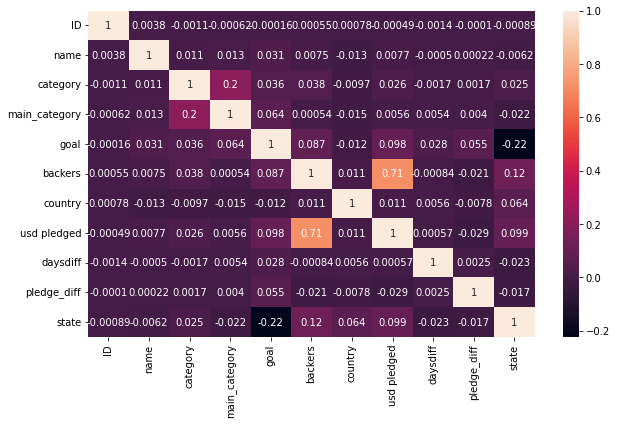

In [20]:
fig = plt.subplots(figsize=(10,6))
corr = df.corr()
sns.heatmap(corr,annot=True)

In [21]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.7:
            if columns[j]:
                columns[j] = False
selected_columns = corr.columns[columns]
selected_columns = selected_columns.union(['deadline','launched'])
data = df[selected_columns]
data.head()

,ID,backers,category,country,daysdiff,deadline,goal,launched,main_category,name,pledge_diff,state
0,148182,0,107,9,59,2015-10-09,1061,2015-08-11,12,275547,745.69,0
1,148183,3,92,20,45,2013-02-26,8397,2013-01-12,6,302148,44780.00,0
2,148184,1,89,20,30,2012-04-16,3680,2012-03-17,10,285705,4999.00,0
3,148185,14,55,20,56,2015-08-29,6892,2015-07-04,6,65251,18217.00,0
4,148186,224,122,20,35,2016-04-01,8569,2016-02-26,7,170273,-2375.00,1


<AxesSubplot:>

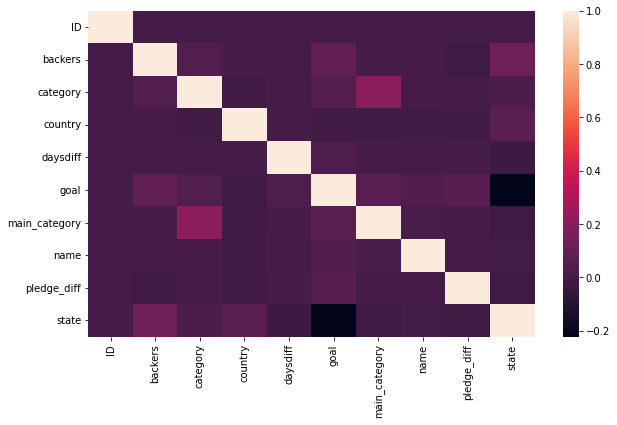

In [22]:
fig = plt.subplots(figsize=(10,6))
sns.heatmap(data.corr())

In [23]:
df.dtypes

ID                        int32
name                      int32
category                  int32
main_category             int32
deadline         datetime64[ns]
goal                      int32
launched         datetime64[ns]
backers                   int32
country                   int32
usd pledged             float64
daysdiff                  int64
pledge_diff             float64
state                     int32
dtype: object

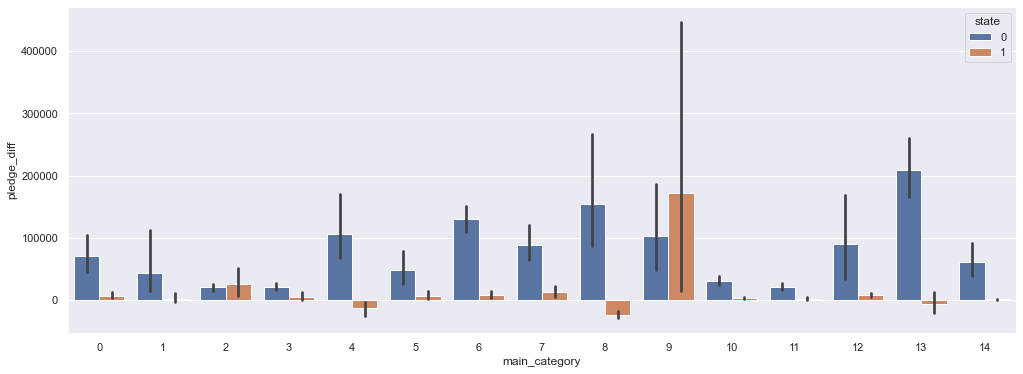

In [26]:
sns.set(rc={"figure.figsize":(17, 6)})
ax = sns.barplot(x='main_category',y='pledge_diff',hue='state',data=df[df['goal']<19000])#.set(title='rape vs crime')

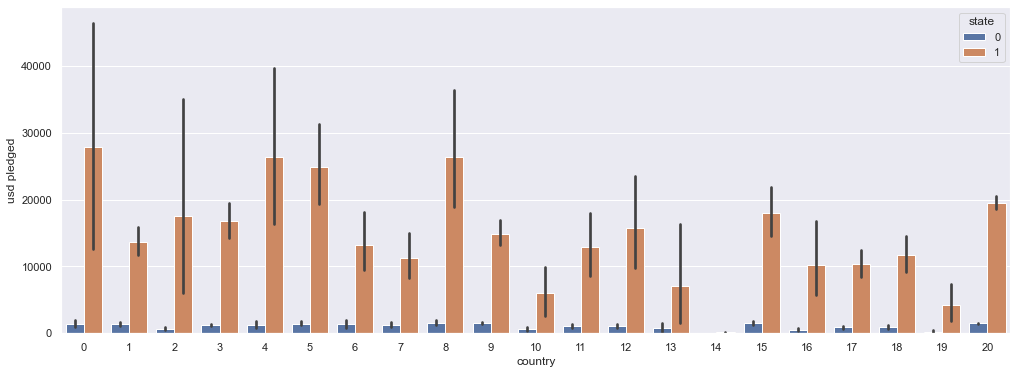

In [27]:
sns.set(rc={"figure.figsize":(17, 6)})
ax = sns.barplot(x='country',y='usd pledged',hue='state',data=df[df['goal']<19000])#.set(title='rape vs crime')

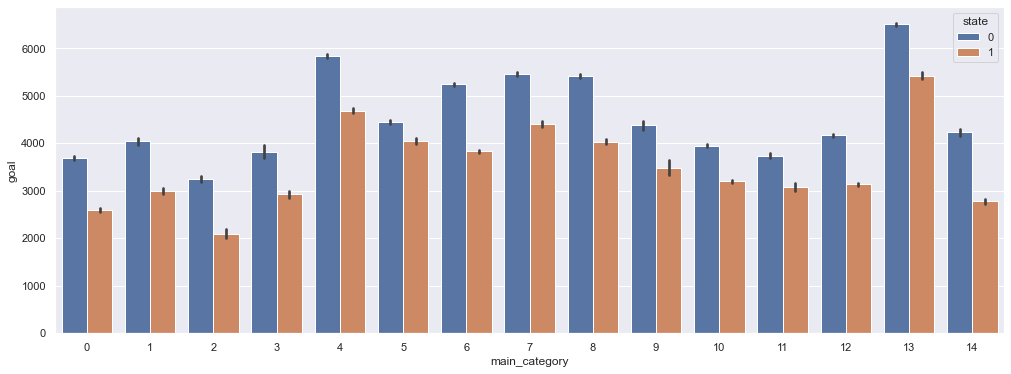

In [28]:
sns.set(rc={"figure.figsize":(17, 6)})
ax = sns.barplot(x='main_category',y='goal',hue='state',data=df[df['goal']<19000])#.set(title='rape vs crime')

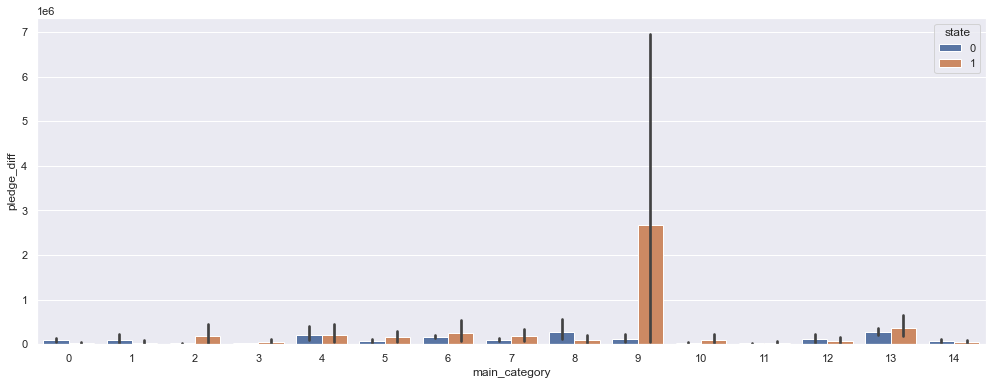

In [30]:
ax = sns.barplot(x='main_category',y='pledge_diff',hue='state',data=df[df['backers']<5])#.set(title='rape vs crime')

# how many successful businesses had reasonable goals? how many successful surpassed the goal or did not pass the goal but still succeeded? find the relationship between success and the goal, pledge

<AxesSubplot:xlabel='usd pledged', ylabel='goal'>

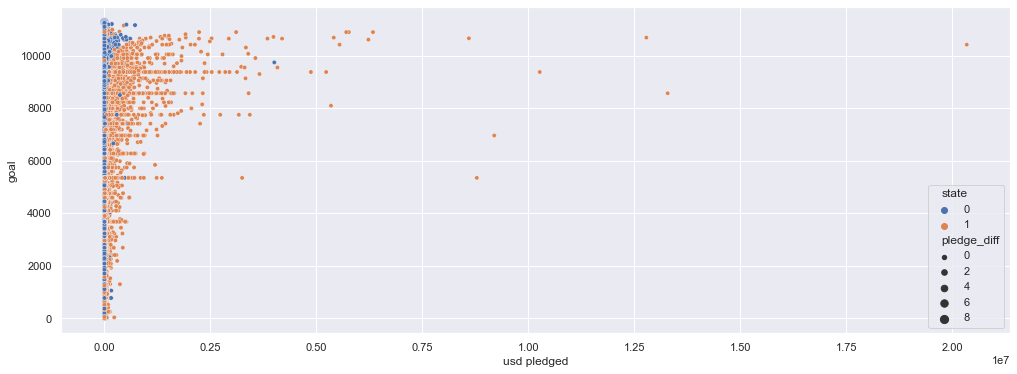

In [31]:
sns.scatterplot(x='usd pledged',y='goal',hue='state' ,size='pledge_diff',data=df[df['goal']<19000])#.set(title='rape vs crime')

<AxesSubplot:xlabel='pledge_diff', ylabel='goal'>

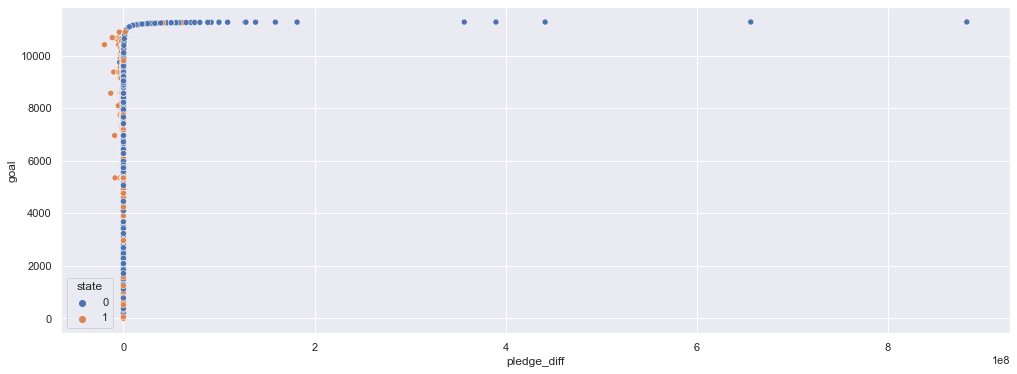

In [32]:
sns.scatterplot(x='pledge_diff',y='goal',hue='state',data=df[df['goal']<19000])#.set(title='rape vs crime')

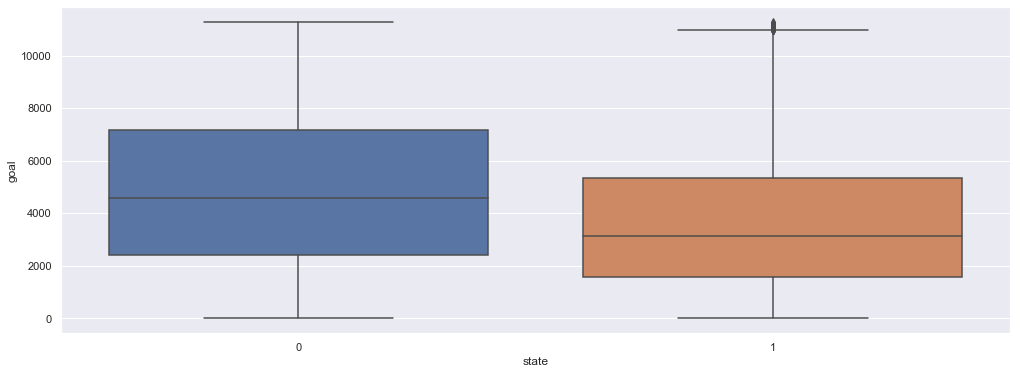

In [33]:
ax = sns.boxplot(x='state',y='goal',data=df[df['goal']<19000])#.set(title='rape vs crime')

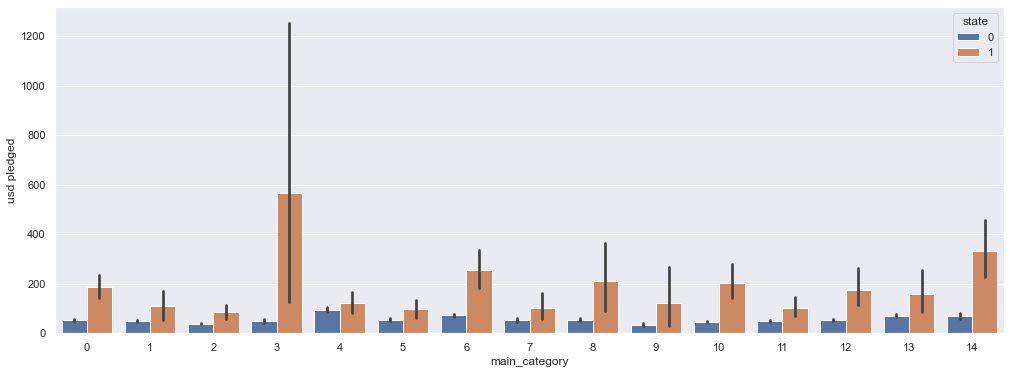

In [34]:
ax = sns.barplot(x='main_category',y='usd pledged',hue='state',data=df[df['backers']<5])#.set(title='rape vs crime')

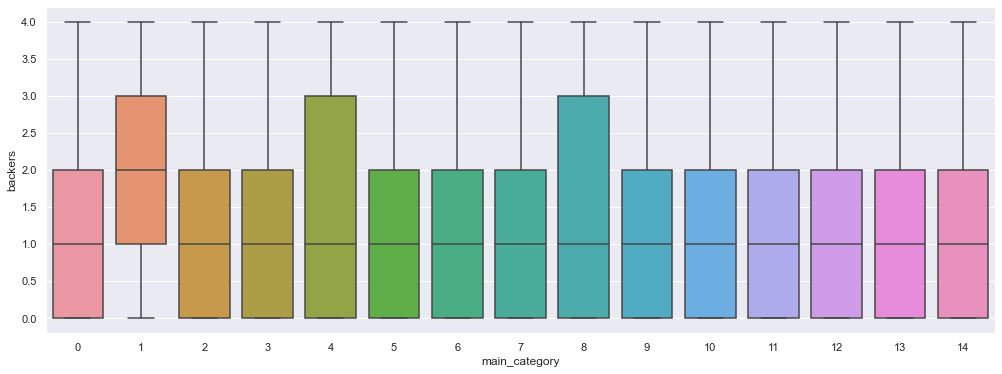

In [35]:
ax = sns.boxplot(y='backers',x='main_category',data=df[df['backers']<5])#.set(title='rape vs crime')

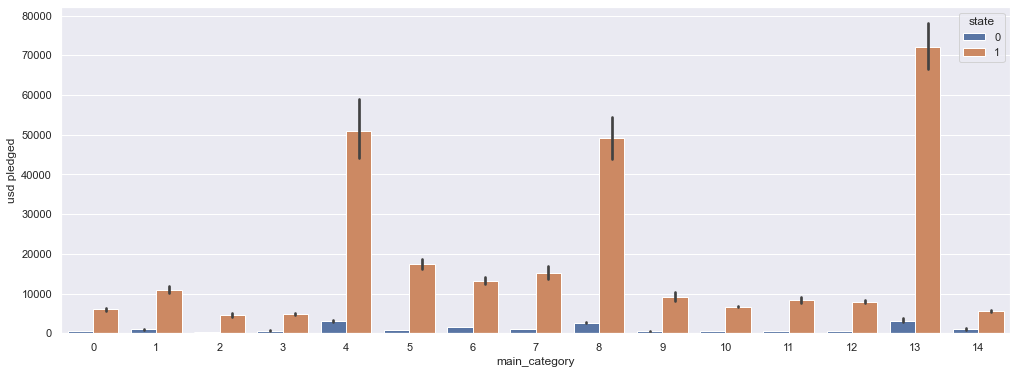

In [36]:
sns.set(rc={"figure.figsize":(17, 6)})
ax = sns.barplot(x='main_category',y='usd pledged',hue='state',data=df)

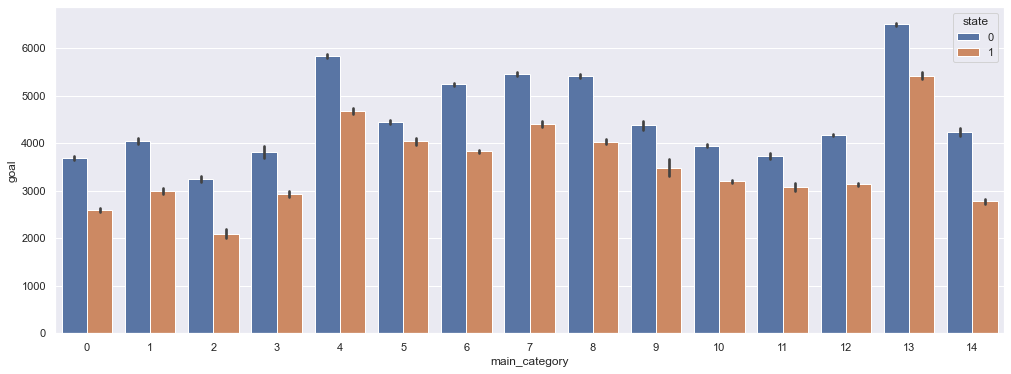

In [37]:
sns.set(rc={"figure.figsize":(17, 6)})
ax = sns.barplot(x='main_category',y='goal',hue='state',data=df)

<AxesSubplot:xlabel='state', ylabel='count'>

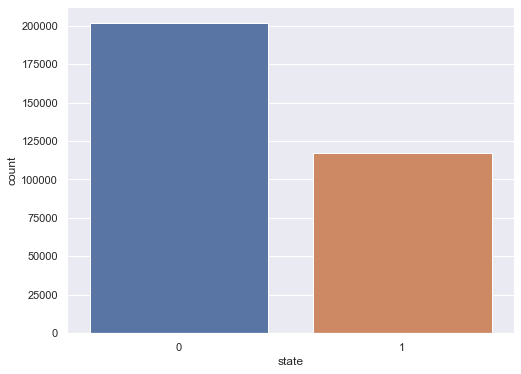

In [38]:
sns.set(rc={"figure.figsize":(8, 6)})
sns.countplot(data=df,x = 'state')

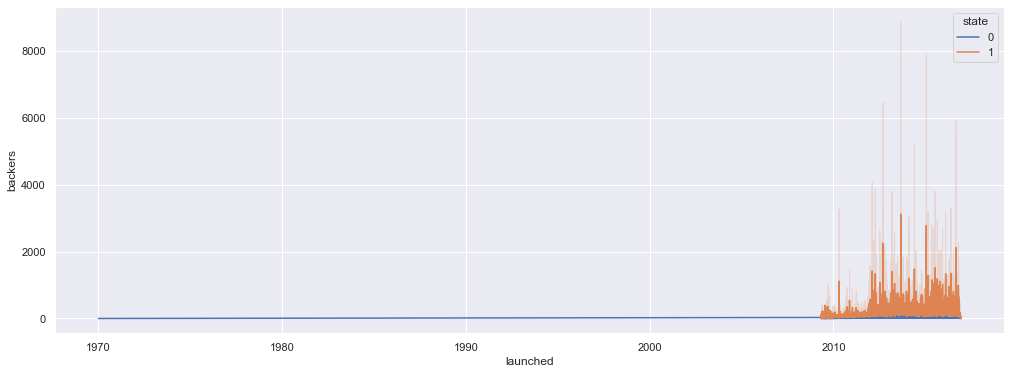

In [39]:
sns.set(rc={"figure.figsize":(17, 6)})
ax = sns.lineplot(x='launched',y='backers',hue='state',data=df)#.set(title='rape vs crime')

# Logistic Regression

In [108]:
X =  data[['backers','main_category','goal','daysdiff']]
y = list(data['state'])


#X = scale(X)

columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = columns)
X.head()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30)

In [109]:
X.shape

(319324, 4)

In [110]:
data.columns

Index(['ID', 'backers', 'category', 'country', 'daysdiff', 'deadline', 'goal',
       'launched', 'main_category', 'name', 'pledge_diff', 'state'],
      dtype='object')

In [111]:
#scale categorical variables?

In [112]:
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [113]:
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.437401
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               223526
Model:                          Logit   Df Residuals:                   223522
Method:                           MLE   Df Model:                            3
Date:                Sat, 25 Dec 2021   Pseudo R-squ.:                  0.3353
Time:                        18:33:38   Log-Likelihood:                -97771.
converged:                       True   LL-Null:                   -1.4708e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
backers          18.9402      0.088    216.175      0.000      18.768      19.112
main_category     0

In [114]:
np.exp(model.params)

backers          1.681232e+08
main_category    1.020585e+00
goal             2.592845e-01
daysdiff         5.494118e-01
dtype: float64

In [115]:
y_pred = model.predict(X_test)
y_pred = list(map(round, y_pred))

In [116]:
from sklearn.metrics import classification_report, confusion_matrix


print('Accuracy:',round(accuracy_score(y_test, y_pred)*100,2),'%')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

Accuracy: 82.62 %
=== Confusion Matrix ===
[[58246  2461]
 [14184 20907]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.80      0.96      0.87     60707
           1       0.89      0.60      0.72     35091

    accuracy                           0.83     95798
   macro avg       0.85      0.78      0.80     95798
weighted avg       0.84      0.83      0.82     95798



In [117]:
lr = LogisticRegression() 
lr = lr.fit(X_train, y_train) 

In [118]:
y_pred = model.predict(X_test)
y_pred = list(map(round, y_pred))

In [119]:
y_pred = lr.predict(X_test)
y_pred = list(map(round, y_pred))

In [120]:
from sklearn.metrics import classification_report, confusion_matrix


print('Accuracy:',round(accuracy_score(y_test, y_pred)*100,2),'%')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

Accuracy: 86.99 %
=== Confusion Matrix ===
[[57283  3424]
 [ 9042 26049]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     60707
           1       0.88      0.74      0.81     35091

    accuracy                           0.87     95798
   macro avg       0.87      0.84      0.85     95798
weighted avg       0.87      0.87      0.87     95798



# K Nearest Neighbor

In [121]:
classifier = KNeighborsClassifier(n_neighbors = 4,metric='euclidean')
classifier.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=4)

In [122]:
y_pred  =  classifier.predict(X_test)

In [123]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
print('Accuracy:',round(accuracy_score(y_test, y_pred)*100,2),'%')
print(classification_report(y_test, y_pred))

[[58030  2677]
 [ 7377 27714]]
Accuracy: 89.51 %
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     60707
           1       0.91      0.79      0.85     35091

    accuracy                           0.90     95798
   macro avg       0.90      0.87      0.88     95798
weighted avg       0.90      0.90      0.89     95798



# Naive Bayes

In [124]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [125]:
y_pred  =  classifier.predict(X_test)

In [126]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
print('Accuracy:',round(accuracy_score(y_test, y_pred)*100,2),'%')
print(classification_report(y_test, y_pred))

[[60111   596]
 [27880  7211]]
Accuracy: 70.27 %
              precision    recall  f1-score   support

           0       0.68      0.99      0.81     60707
           1       0.92      0.21      0.34     35091

    accuracy                           0.70     95798
   macro avg       0.80      0.60      0.57     95798
weighted avg       0.77      0.70      0.64     95798

